# Final Project:                                          McGill - COMP767 - FALL 2019 
Student name: Antonios Valkanas (ID: 260672034)

## Ising Model Empirical Testing of IMCMC

#### Ising model
The Ising model is fully expressed using a symmetric adjacency matrix $A$ (```adj```):
\begin{align}
  p(x) = \frac{1}{Z} \exp(\sum_{i} A_{i,i}x_i + \sum_{i,j < i} x_i A_{i,j}x_j) \quad x_i \in \{-1,+1\}
\end{align}
In words, the diagonal of $A$ represents the local field and interactions are captured by the remaining non-zero elements of $A$/


First we define MCMC and IMCMC

In [4]:
import numpy as np
import matplotlib.pylab as plt
import networkx as nx
np.random.seed(12345)
import timeit
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from utils import tensor_mult, draw_graph, logistic
from inference import Inference, CliqueTreeInference
from IPython.core.debugger import set_trace
import seaborn as sn
sn.set_context('notebook')
%matplotlib inline
from matplotlib import colors
from random import randint

In [5]:
def initial_state(dim):
    '''
    Create a dim by dim array of numbers chosen randomly from -1 or 1.
    '''
    random_state = np.random.choice([-1,1], size = (dim,dim))
    
    return random_state

def plot_grid(grid, title=None):
    '''
    Plot grid with -1 being black and 1 being white with an option to add a title.
    '''
    # Create discrete colormap
    cmap = colors.ListedColormap(['black', 'white'])
    bounds = [-2,0,2]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    # Make plot
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap = cmap, norm=norm)
    ax.set_title(title)

In [6]:
class MCMC():
    """
    implements MCMC for an Ising model
    for  p(x) \propto exp(+\sum_{i,j<i} x_i x_j adj[i,j] + \sum_{i} x_i adj[i,i]) for  x_i \in {-1,+1}
    """
    def __init__(self,
                 adj,
                 H,# self interaction
                 J,# cross interaction
                 beta, # inverse of temperature parameter
                 verbosity=0,
                 max_iters=200000, # max number of iterations
                 informed_start=None,  
    ):
        self.max_iters = max_iters
        self.verbosity = verbosity
        self.beta = beta
        self.state = None
        self.marginals = None
        self.magnetizations = None
        self.converged = False
        self.informed_start = informed_start
        self.H = H
        self.J = J
        self.adj = adj
        self._initialize()


    def _initialize(self):
        if self.informed_start is None:
            self.state = initial_state(int(np.sqrt(self.H.shape[0])))
            if self.verbosity > 1:
                print('Random start',self.state)
        else:
            self.state = self.informed_start
            if self.verbosity > 1:
                print('Random start',self.state)
        self.converged = False
        self.marginals = np.zeros(self.H.shape[0])
        self.magnetizations = np.zeros(self.max_iters)
    
    def _inference(self):
        if self.verbosity > 0:
            print("Running MCMC", flush = True)
        
        def get_local_energy(grid, x, y):
            '''
            Find the energy change due to a spin flip of one node.
            '''
            n = grid.shape[0]
            delta_energy = self.H[n*x+y] # Self interaction
            
            if (x != 0): # Above
                delta_energy += self.J * grid[x-1,y]

            if (x != n-1): # Below
                delta_energy += self.J * grid[x+1,y]

            if (y != 0): # Left
                delta_energy += self.J * grid[x,y-1]

            if (y != n-1): # Right
                delta_energy += self.J * grid[x,y+1]
                
            delta_energy = 2 * (grid[x,y]) * delta_energy

            return delta_energy
        
        # Initialization
        n = self.state.shape[0]
        adj = self.adj.copy()
        t = 1
        num_rejects = 0
        magnetizations = []
        state_hist = []
        state_hist.append(self.state.flatten())
        magnetizations.append(np.sum(self.state.flatten()))
        
        while t < self.max_iters:
            t+=1
            i = randint(0,n-1)
            j = randint(0,n-1)
            
            # Spin the flip
            temp_state = self.state.copy()
            temp_state[i,j] *= -1
            
            # Calculate Proposal's effect on Hamiltonian
            delta_energy = get_local_energy(self.state, i,j)
            if delta_energy < 0 or np.random.random() < np.exp(-delta_energy*self.beta):
                self.state = temp_state.copy()
                state_hist.append(self.state.flatten())
                magnetizations.append(np.sum(self.state.flatten()))
            else:
                num_rejects += 1
                state_hist.append(self.state.flatten())
                magnetizations.append(np.sum(self.state.flatten()))
            
        new_marginals_p = (np.sum(np.array(state_hist), axis = 0) + t)/(2*t)
        self.marginals = new_marginals_p
        self.magnetizations = np.array(magnetizations)
        
        self.marginals = new_marginals_p
        if self.verbosity > 0:
            print("Done, proportion of rejects:", num_rejects/t, flush = True)

    def get_marginal(self, target):
        if not self.converged:
            self._inference()
            self.converged = True
        mrg = (self.marginals)[target]
        return mrg
    
    def get_magnetizations(self):
        if not self.converged:
            self._inference()
            self.converged = True
        return self.magnetizations
    
    def get_partition(self):
        if not self.converged:
            self._inference()
            self.converged = True
        mrg = self.marginals
        return np.exp(2*self.marginals - 1).sum()

In [19]:
size = 8
j = 0.05
h = np.random.uniform(-1,1,size*size)
T = 1

tree = nx.grid_2d_graph(size,size)
n = nx.number_of_nodes(tree)
x_0 = initial_state(size)
mask = np.array(nx.adjacency_matrix(tree).todense(), dtype = np.float64)

# create interactions over the edges
row,col = np.diag_indices(mask.shape[0])
mask *= 0.15
mask[row,col] = h
adj = mask

# make it symmetric
zero_inds = np.tril_indices_from(adj,-1)
adj[zero_inds] = 0        
adj += adj.T.copy()

# do inference
# to change method change following line to LBP or MF
true_margs = CliqueTreeInference(adj).get_marginal(list(range(adj.shape[0])))            
mcmc_margs = MCMC(adj = adj, H = h, J = j, beta = 1, verbosity=0).get_marginal(list(range(adj.shape[0]))).flatten()

print('mean error rand:', np.mean(np.abs(true_margs - mcmc_margs)))

true_mag = np.sum(2*true_margs - 1)
length = 1000
line = [true_mag for i in range(length)]


map_start = (np.rint(true_margs)*2-1).reshape(int(np.sqrt(adj.shape[0])),int(np.sqrt(adj.shape[0])))

mcmc_margs_2 = MCMC(adj = adj, H = h, J = j, beta = 1, verbosity=1, informed_start = map_start).get_marginal(list(range(adj.shape[0]))).flatten()
print('mean error informed:', np.mean(np.abs(true_margs - mcmc_margs_2)))


magn = MCMC(adj = adj, H = h, J = j, beta = 1/T, verbosity=1).get_magnetizations()
magn_2 = MCMC(adj = adj, H = h, J = j, beta = 1/T, verbosity=1, informed_start = map_start).get_magnetizations()

mean error rand: 0.10952670049487662
Running MCMC
Done, proportion of rejects: 0.420865
mean error informed: 0.10533477866729021
Running MCMC
Done, proportion of rejects: 0.42211
Running MCMC
Done, proportion of rejects: 0.42107


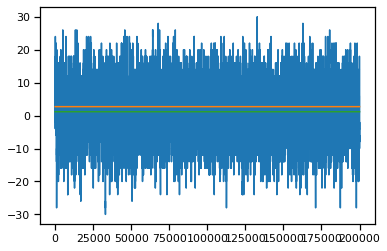

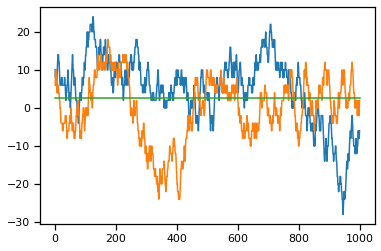

In [20]:
mean_line = [true_mag for i in range(magn.shape[0])]
mean_line_2 = [magn.mean() for i in range(magn.shape[0])]

plt.plot(magn)
plt.plot(mean_line)
plt.plot(mean_line_2)
plt.show()

plt.plot(magn[:length])
plt.plot(magn_2[:length])
plt.plot(line[:length])
plt.show()
# plt.plot(magn[-500:])
# sn.distplot(magn)

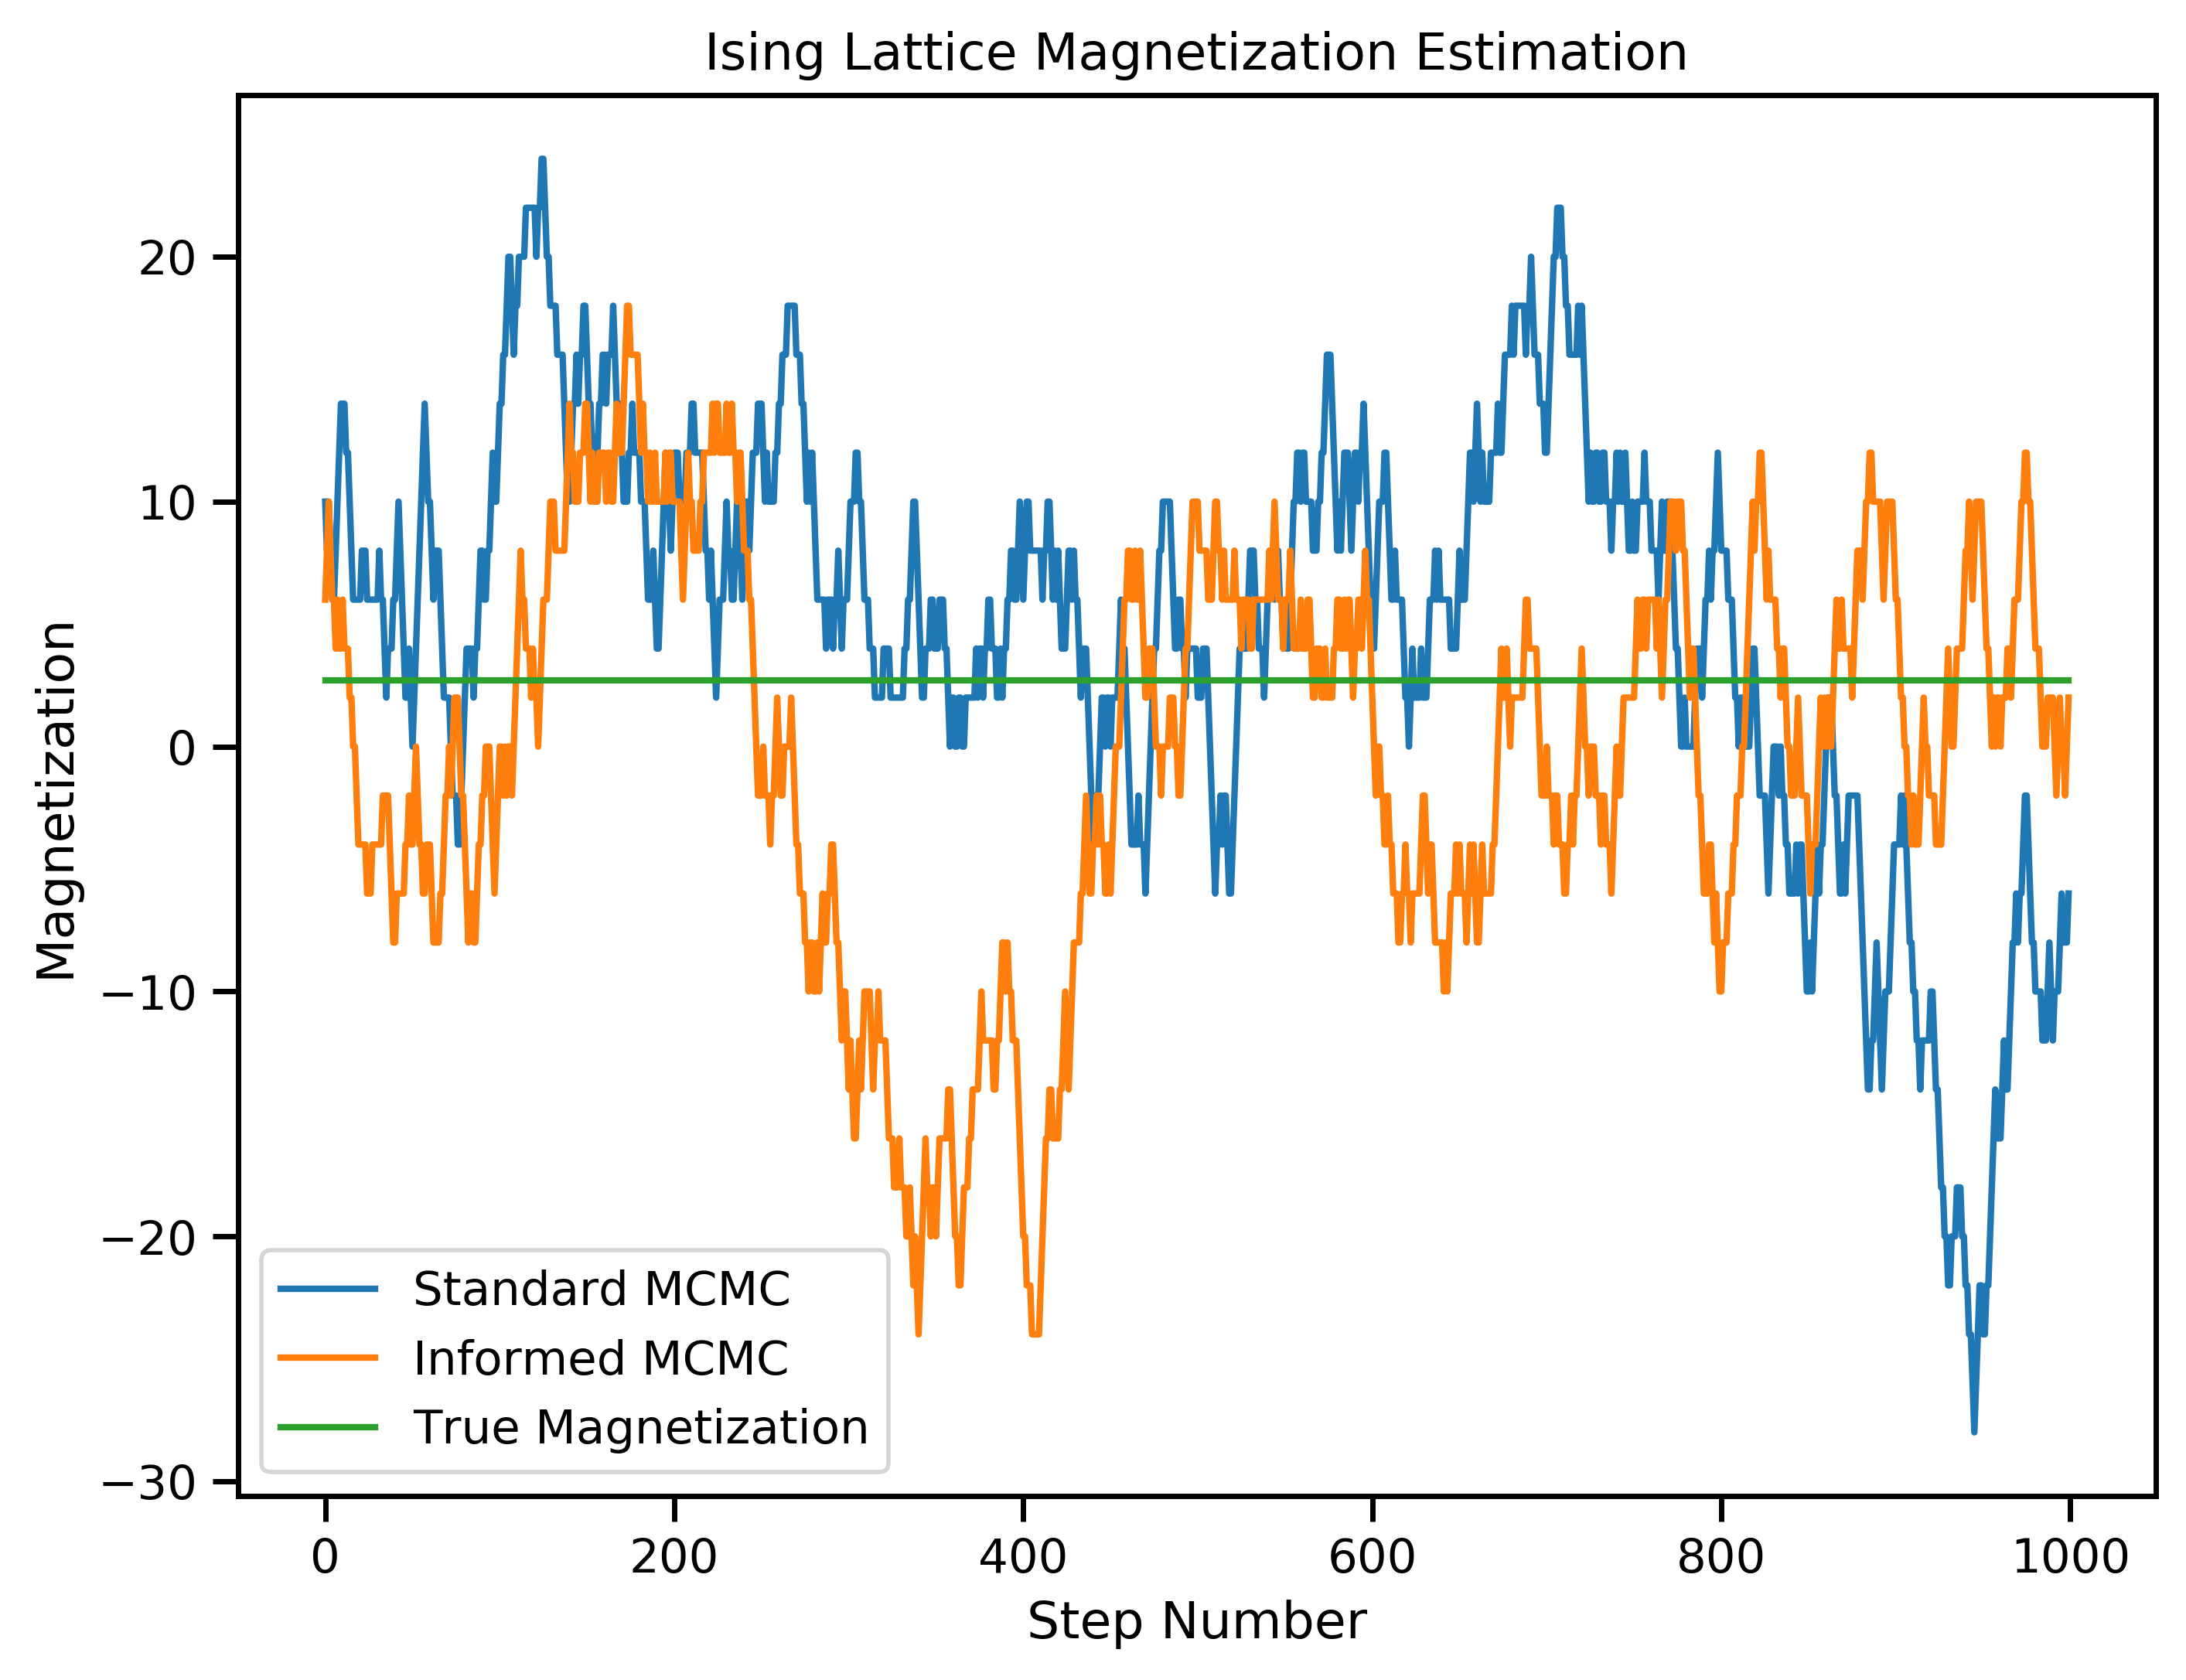

In [21]:
length = 1000
_line = [true_mag for i in range(length)]
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=400)
plt.plot(magn[:length], label = 'Standard MCMC')
plt.plot(magn_2[:length], label = 'Informed MCMC')
plt.plot(_line[:length],label = 'True Magnetization')
plt.xlabel('Step Number')
plt.ylabel('Magnetization')
plt.title('Ising Lattice Magnetization Estimation')
plt.legend()
# plt.savefig('8x8Ising1000Steps')
plt.show()

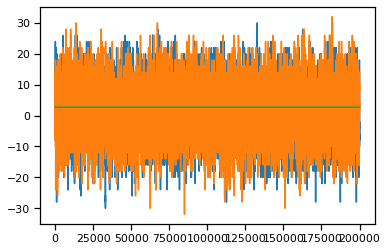

In [22]:
plt.plot(magn)
plt.plot(magn_2)
plt.plot(mean_line)
plt.show()

In [23]:
print(np.mean(magn), np.std(magn))
print(np.mean(magn_2), np.std(magn_2))
print(true_mag)

1.1715 7.4374153944767665
1.11533 7.582222562751637
2.7119460005716687


In [24]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result

In [25]:
print(np.abs(autocorr(magn)).mean())
print(np.abs(autocorr(magn_2)).mean())

156356.25245063112
146038.98514746287


In [26]:
s1 = (autocorr(magn))
s2 = (autocorr(magn_2))

In [27]:
s1 = s1/s1.max()
s2 = s2/s2.max()

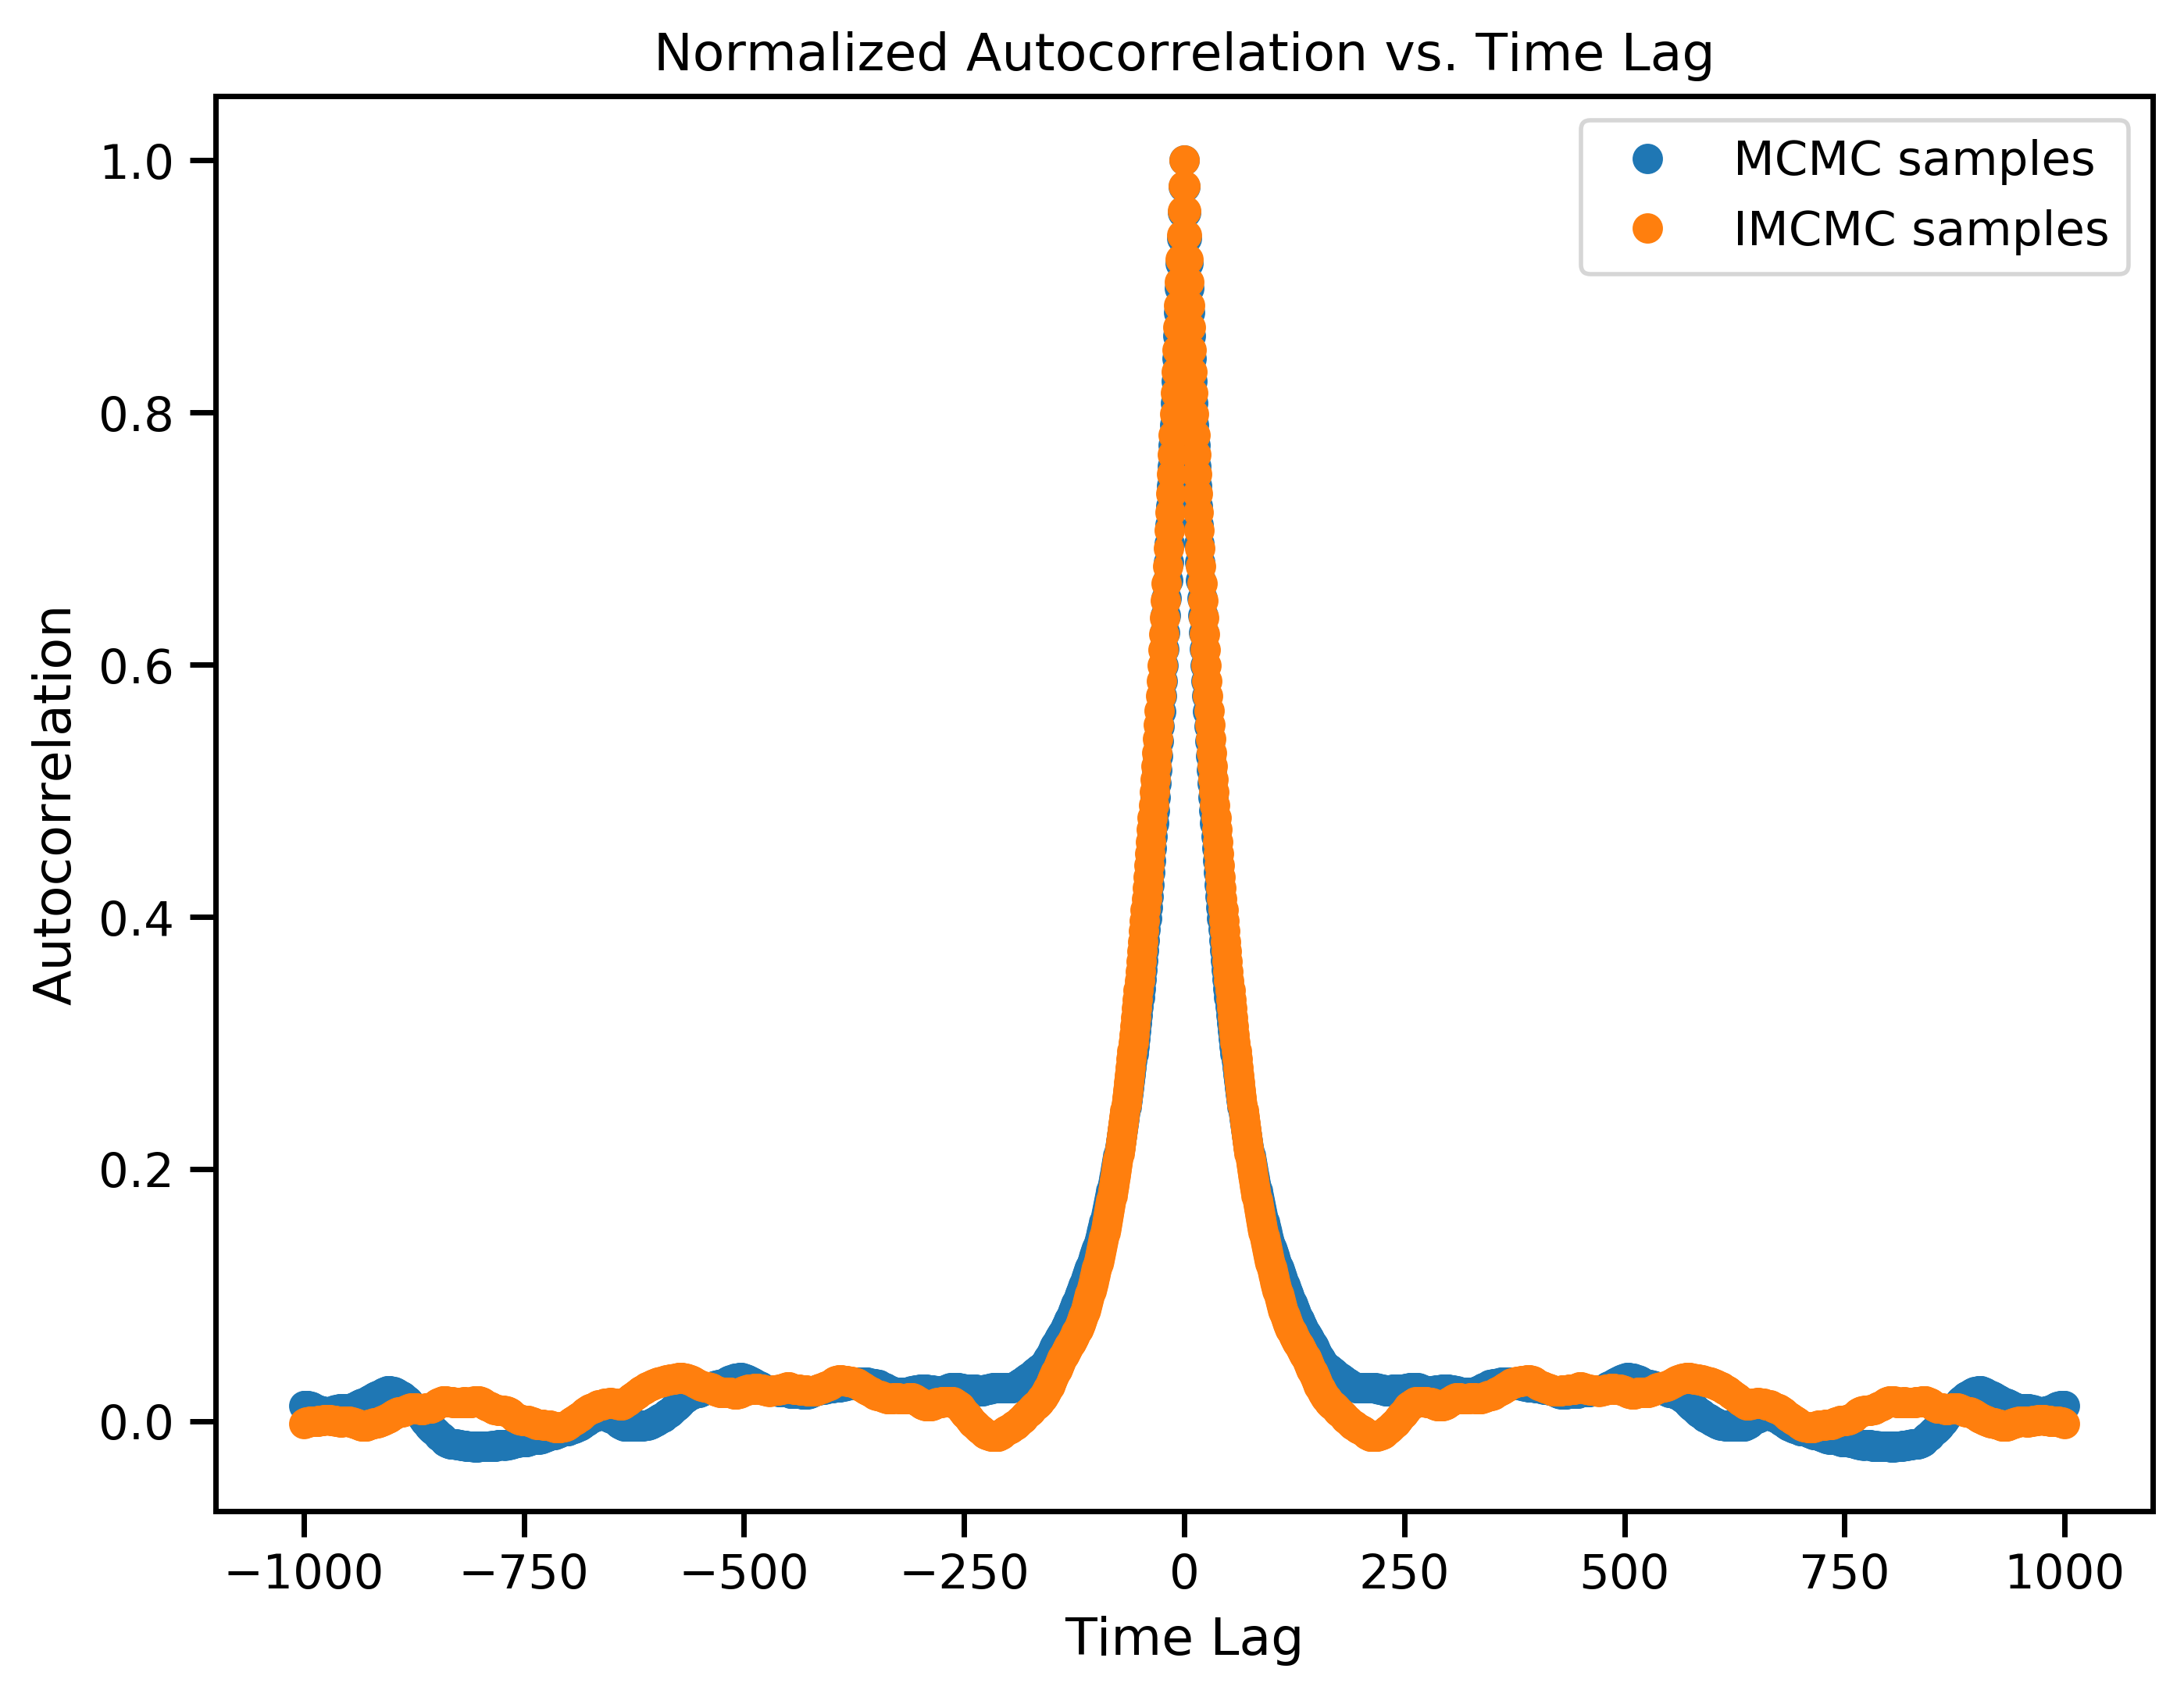

In [28]:
figure(num=None, figsize=(8, 6), dpi=400)
plt.xlabel('Time Lag')
plt.ylabel('Autocorrelation')
plt.title('Normalized Autocorrelation vs. Time Lag')
plt.acorr(magn-np.mean(magn), normed=True, usevlines=False, maxlags=1000, label='MCMC samples')
plt.acorr(magn_2-np.mean(magn_2), normed=True, usevlines=False, maxlags=1000, label='IMCMC samples')
plt.legend()
# plt.savefig('autocorr')
plt.show()

In [145]:
def estimate_ess(n, cor):
    return n/(1+np.sum(cor)/2)

In [146]:
estimate_ess(300000,s1)

16.635834119645303

In [147]:
estimate_ess(300000,s2)

16.931290747226285

In [55]:
def run_experiment_ess(size = 8, num_exp = 10, maxiters = 300000):
    ess_mcmc = []
    ess_imcmc = []
    for z in range(num_exp):
#         print(z)
        j = 0.15
        h = np.random.uniform(-1,1,size*size)
#         print(np.abs(h).mean(), np.std(h))
        T = 1

        tree = nx.grid_2d_graph(size,size)
        n = nx.number_of_nodes(tree)
        x_0 = initial_state(size)
        mask = np.array(nx.adjacency_matrix(tree).todense(), dtype = np.float64)

        # create interactions over the edges
        row,col = np.diag_indices(mask.shape[0])
        mask *= j
        mask[row,col] = h
        adj = mask

        # make it symmetric
        zero_inds = np.tril_indices_from(adj,-1)
        adj[zero_inds] = 0        
        adj += adj.T.copy()

        # do inference
        # to check other method change the next line
        true_margs = CliqueTreeInference(adj).get_marginal(list(range(adj.shape[0])))            

        true_mag = np.sum(2*true_margs - 1)

        map_start = (np.rint(true_margs)*2-1).reshape(int(np.sqrt(adj.shape[0])),int(np.sqrt(adj.shape[0])))

        magn = MCMC(adj = adj, H = h, J = j, beta = 1/T, max_iters=maxiters).get_magnetizations()
        magn_2 = MCMC(adj = adj, H = h, J = j, beta = 1/T, max_iters=maxiters, informed_start = map_start).get_magnetizations()
        
        s1 = (autocorr(magn))
        s2 = (autocorr(magn_2))
        s1 = s1/s1.max()
        s2 = s2/s2.max()
        
        ess_mcmc.append(estimate_ess(maxiters,s1))
        ess_imcmc.append(estimate_ess(maxiters,s2))
#         print('mcmc:',estimate_ess(maxiters,s1))
#         print('i-mcmc',estimate_ess(maxiters,s2))
        
    return ess_mcmc, ess_imcmc

In [121]:
n = 10
runs = 1000
steps = 1000

ess_mcmc, ess_imcmc = run_experiment_ess(size = n, num_exp = runs, maxiters = steps)
ess_mcmc = np.array(ess_mcmc)
ess_imcmc = np.array(ess_imcmc)
# print((ess_imcmc - ess_mcmc)/ess_mcmc)

In [122]:
print('i-mcmc/mcmc ratio (mean, std):', ((ess_imcmc-ess_mcmc)/ess_mcmc).mean(),  ((ess_imcmc-ess_mcmc)/ess_mcmc).std())

i-mcmc/mcmc ratio (mean, std): 6.32245900761781 26.34558316808611


In [123]:
ess_mcmc.mean()

54.154506759515805

In [124]:
ess_mcmc.std()

150.63974805786432

In [125]:
ess_imcmc.mean()

58.813737247705646

In [126]:
ess_imcmc.std()

168.70810077935994

In [177]:
def get_normalizing_constant(size = 8, num_exp = 10, maxiters = 10000):
    Z_mcmc = []
    Z_imcmc = []

    for z in range(num_exp):
        j = 0.15
        size = 16

        h = np.random.uniform(-1,1,size*size)
        #         print(np.abs(h).mean(), np.std(h))
        T = 256
        tree = nx.grid_2d_graph(size,size)
        n = nx.number_of_nodes(tree)
        x_0 = initial_state(size)
        mask = np.array(nx.adjacency_matrix(tree).todense(), dtype = np.float64)

        # create interactions over the edges
        row,col = np.diag_indices(mask.shape[0])
        mask *= j
        mask[row,col] = h
        adj = mask

        # make it symmetric
        zero_inds = np.tril_indices_from(adj,-1)
        adj[zero_inds] = 0        
        adj += adj.T.copy()

        # do inference
        # To change method change the next line
        true_margs = CliqueTreeInference(adj).get_marginal(list(range(adj.shape[0])))            

        true_mag = np.sum(2*true_margs - 1)

        map_start = (np.rint(true_margs)*2-1).reshape(int(np.sqrt(adj.shape[0])),int(np.sqrt(adj.shape[0])))

        Z_mcmc.append(MCMC(adj = adj, H = h, J = j, beta = 1/T, max_iters=maxiters).get_partition())
        Z_imcmc.append(MCMC(adj = adj, H = h, J = j, beta = 1/T, max_iters=10000, informed_start = map_start).get_partition())

    return (Z_imcmc, Z_mcmc)

In [178]:
iZ, Z = get_normalizing_constant(size = 16, num_exp = 10, maxiters = 10000)

Z (imcmc) (mean, std): 257.54378383113 2.6296520753288313
Z (mcmc) (mean, std): 258.2794084449418 2.328878630269278


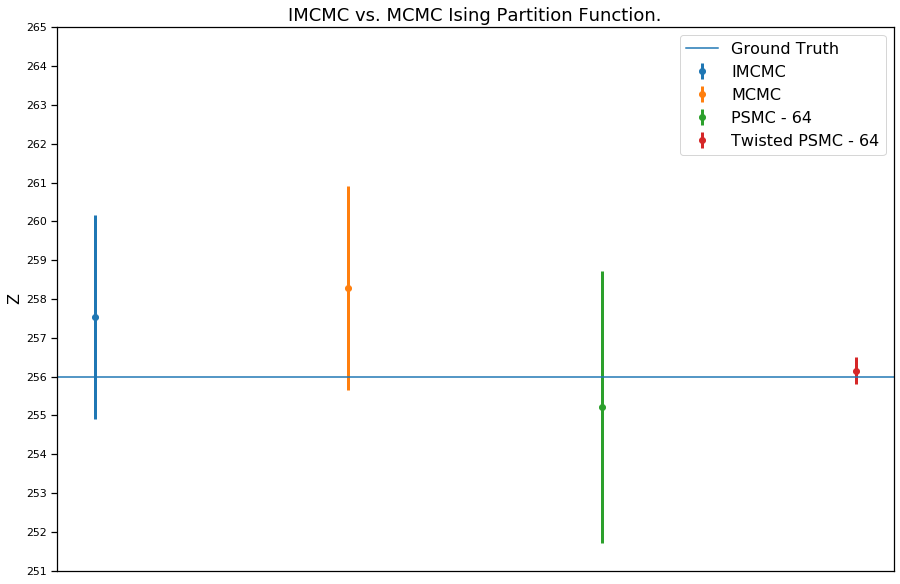

In [187]:
iZ = np.array(iZ)
Z = np.array(Z)

print('Z (imcmc) (mean, std):',iZ.mean(),  iZ.std())
print('Z (mcmc) (mean, std):',Z.mean(),  Z.std())


plt.figure(figsize=(15,10))
plt.errorbar([1], iZ.mean(), yerr= iZ.std(), fmt='o', elinewidth=3)
plt.errorbar([2], Z.mean(), yerr= iZ.std(), fmt='o',elinewidth=3)
plt.errorbar([3], [255.21], yerr= [3.5], fmt='o',elinewidth=3)
plt.errorbar([4], [256.15], yerr= [0.35], fmt='o',elinewidth=3)
plt.axhline(y=256, linestyle='-', label = "Ground Truth")
plt.xticks([])
plt.yticks([251,252,253,254,255,256,257,258,259,260,261,262,263,264,265])
plt.ylabel("Z", fontsize=16)
plt.legend(["Ground Truth", "IMCMC", "MCMC", "PSMC - 64", "Twisted PSMC - 64"], fontsize=16)
plt.title("IMCMC vs. MCMC Ising Partition Function.", fontsize=18)
# plt.savefig('partition_function')
plt.show()

# The following code is adapted from Assignment 3

## Loopy Belief Propagation


The implementation of loopy-BP.
The BP message $m_{i \to j}$ for a pairwise MRF is the product of all incoming messages, and the relevant factors, marginalized over $x_i$. For the Ising model this is:
\begin{align} 
m_{i \to j}(x_j) \propto (1-\alpha) m^{old}_{i \to j}(x_j) \, + \, \alpha \sum_{x_i \in \{-1,+1\}} \left ( \exp(x_i A_{i,i} + x_i A_{i,j} x_j) \prod_{k \in Nb(i)-j} m_{k \to i}(x_i) \right )
\end{align}
where $\alpha$ called the damping factor helps with the convergence. After convergence the marginals are:
\begin{align}
p(x_i) \propto \exp(x_i A_{i,i}) \prod_{j \in Nb(i)} m_{j \to i}(x_i)
\end{align}

In [203]:
class LBPInference(Inference):
    """
    implements sum-product loopy belief propagation inference 
    for  p(x) \propto exp(+\sum_{i,j<i} x_i x_j adj[i,j] + \sum_{i} x_i adj[i,i]) for  x_i \in {-1,+1}
    """
    def __init__(self,
                 adj,
                 verbosity=0,
                 max_iters=1000,  # max number of iterations
                 damping=.1,  # damping=0 means no damping
                 eps=1e-16,  # threshold for convergence
    ):
        Inference.__init__(self, adj, verbosity=verbosity)
        self.damping = damping
        self.max_iters = max_iters
        # (i,j)th element is the log-ratio of message i->j
        self.msg_new = None
        self.msg_old = None
        self.marginals = None
        self.converged = False
        self.mask = None  # zero-one mask for the adjacency (zero diagonals)
        self.eps = eps
        self._initialize()
        self.adj = adj

    def update_adjacency(self, new_adj):
        self.adj = new_adj
        self._initialize()

    def _initialize(self):
        n = self.adj.shape[0]
        self.msg_new = np.zeros((n , n))
        self.msg_old = np.zeros((n , n))
        self.marginals = np.zeros(n)
        mask = (self.adj != 0)
        np.fill_diagonal(mask, 0)
        self.mask = mask
        self.converged = False

    def _apply_damping(self, msg_new, msg_old):
        #convert to probability
        msg_new_p = logistic(msg_new)
        msg_old_p = logistic(msg_old)
        msg_p = msg_old_p * (self.damping) + msg_new_p * (1. - self.damping)
        # convert back to log-ratio
        msg = np.log(msg_p) - np.log(1. - msg_p)
        return msg
    
    def _inference(self):
        if self._verbosity > 0:
            print("running BP", flush = True)
        
        # >>>> YOUR CODE HERE >>>>>>>
        def apply_damping(msg_new, msg_old, damping):
            #convert to probability
            msg_new_p = logistic(msg_new)
            msg_old_p = logistic(msg_old)
            msg_p = msg_old_p * (damping) + msg_new_p * (1. - damping)
            # convert back to log-ratio
            msg = np.log(msg_p) - np.log(1. - msg_p)
            return msg
        
        # Initialization
        nonz = np.nonzero(self.adj)
        pairwise_set = set([(nonz[0][i], nonz[1][i]) for i in range(len(nonz[0]))])
        old_msg = np.zeros_like(self.adj)
        new_msg = np.ones_like(self.adj)
        adj = self.adj.copy()
        
        t = 0
        while t < self.max_iters and np.max(np.abs(new_msg - old_msg)) > self.eps:
            t += 1
            old_msg = new_msg.copy()
            for i, j in pairwise_set:
                if i != j :
                    prod_p = 1
                    prod_n = 1
                    for k in range(adj.shape[1]):
                        if k != j and k != i and self.adj[k,i] != 0:
                            prod_p *= logistic(old_msg[k,i])
                            prod_n *= (1-logistic(old_msg[k,i]))
                    new_msg[i,j] = np.exp(-adj[i,i] - adj[i,j]) * prod_n + np.exp(adj[i,i] + adj[i,j]) * prod_p
                    complement = np.exp(-adj[i,i] + adj[i,j]) * prod_n + np.exp(adj[i,i] - adj[i,j]) * prod_p
                    new_msg[i,j] = np.log(new_msg[i,j]) - np.log(complement)
            
            new_msg = apply_damping(new_msg, old_msg, self.damping)

        new_marginals_p = np.ones(adj.shape[0])
        new_marginals_n = np.ones(adj.shape[0])
        for i in range(adj.shape[0]):
            new_marginals_p[i] = np.exp(adj[i,i])
            new_marginals_n[i] = np.exp(-adj[i,i])
            for j in range(adj.shape[1]):
                if self.adj[j,i] != 0 and j != i:
                    new_marginals_p[i] *= logistic(new_msg[j,i])
                    new_marginals_n[i] *= (1 - logistic(new_msg[j,i]))
                    
        new_marginals_p /= (new_marginals_p + new_marginals_n) 
        # >>>> YOUR CODE HERE >>>>>>>
        
        self.marginals = new_marginals_p
        if self._verbosity > 0:
            print("finished after {} iterations!".format(t), flush = True)
                
    def get_marginal(self, target):
        if not self.converged:
            self._inference()
            self.converged = True
        mrg = (self.marginals)[target]
        return mrg

If the implementation above is correct, it should return exact marginals for the tree structure below. You can use this to debug your code (We are comparing the ```LBPInference``` marginals against the exact values returned by ```CliqueTreeInference```.) 

In [204]:
#build a tree 
tree = nx.balanced_tree(3, 4)
n = nx.number_of_nodes(tree)
mask = np.array(nx.adjacency_matrix(tree).todense())
# create a random interaction over the edges
np.fill_diagonal(mask, 1.)
adj = mask * np.random.randn(n , n)
# make it symmetric
zero_inds = np.tril_indices_from(adj,-1)
adj[zero_inds] = 0
adj += adj.T.copy()
# do inference
true_margs = CliqueTreeInference(adj).get_marginal(list(range(adj.shape[0])))            
bp_margs = LBPInference(adj, verbosity = 1).get_marginal(list(range(adj.shape[0])))

assert np.max(np.abs(true_margs - bp_margs)) < 1e-10, "LBP marginals are not exact"

running BP
finished after 31 iterations!


## Mean Field

The implementation of naive mean-field. 

In [ ]:
class MFInference(Inference):
    """
    implements parallel update of naive mean-field for the Ising model
    mean-field is guaranteed to converge to a local optima, when updating 
    one coordinate at a time. Here, since for efficiency/simplicity we update all coordinates simultaneously,
    we may need to use damping to help with convergence
    for  p(x) \propto exp(+\sum_{i,j<i} x_i x_j adj[i,j] + \sum_{i} x_i adj[i,i]) for  x_i \in {-1,+1}
    """
    
    def __init__(self,
                 adj,  # adjacency matrix for the Ising model
                 verbosity=0,
                 max_iters=1000,  # max number of iterations
                 eps=1e-16,  # threshold for convergence
                 damping=.5, # because we are using parallel updates, 0 means no damping
    ):
        Inference.__init__(self, adj, verbosity=verbosity)
        self.damping = damping
        self.max_iters = max_iters
        # (i,j)th element is the log-ratio of message i->j
        self.means = None
        self.converged = False
        self.adj_masked = None  # adjacency matrix with zero diagonals
        self.eps = eps
        self._initialize()

    def update_adjacency(self, new_adj):
        self.adj = new_adj
        self._initialize()

    def _initialize(self):
        n = self.adj.shape[0]
        self.means = np.zeros(n)
        adj_masked = self.adj.copy()
        np.fill_diagonal(adj_masked, 0)
        self.adj_masked = adj_masked
        self.converged = False

    def _inference(self):
        if self._verbosity > 0:
            print("running MF", flush = True)
        # >>>> YOUR CODE HERE >>>>>>>
        
        n = self.adj.shape[0]
        adj = self.adj
        t = 0
        temp = np.zeros(n)
        old_temp = np.ones(n)
        q = np.zeros(n)
        mean = 0

        while t < self.max_iters and np.max(np.abs(temp - old_temp)) > self.eps:
            t += 1
            
            old_temp = temp.copy()
            for i in range(n):
                temp[i] = adj[i,i] 
                for j in range(n):
                    if self.adj[i,j] != 0 and j != i:
                        temp[i] += adj[i,j] * old_temp[j]
                temp[i] = 2*logistic(2*temp[i]) - 1
            temp = self.damping * temp + (1 - self.damping) * old_temp

            if self._verbosity > 0 and t % 100 == 0: print(t, np.mean(np.abs(temp - old_temp)))
        self.means = temp
        # >>>> YOUR CODE HERE >>>>>>>
        if self._verbosity > 0:
            print("finished after {} iterations!".format(t), flush = True)
                
    def get_marginal(self, target):
        if not self.converged:
            self._inference()
            self.converged = True
        # converting the mean ([-1,+1] range) to the p(x_i = 1) [0,1] range
        mrg = (self.means[target] + 1.)/2.
        return mrg

In [ ]:
#build a tree 
tree = nx.grid_2d_graph(15,15)
n = nx.number_of_nodes(tree)
mask = np.array(nx.adjacency_matrix(tree).todense())
# create a random interaction over the edges
np.fill_diagonal(mask, 1.)
adj = mask * np.random.randn(n , n)
# make it symmetric
zero_inds = np.tril_indices_from(adj,-1)
adj[zero_inds] = 0        
adj += adj.T.copy()
# do inference
true_margs = CliqueTreeInference(adj).get_marginal(list(range(adj.shape[0])))            
mf_margs = MFInference(adj, verbosity=1).get_marginal(list(range(adj.shape[0])))

print(np.mean(np.abs(true_margs - mf_margs)))
assert np.mean(np.abs(true_margs - mf_margs)) < 1e-1, "MF marginals are not too different"